In [36]:
from aequitas.bias import Bias
from aequitas.group import Group
from aequitas.fairness import Fairness
from ml_utils import Pipeline
import pandas as pd
import numpy as np
import datetime
import logging
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pipeline = Pipeline()

chunk = pipeline.load_chunk(chunksize=5000)
data = chunk
max_chunks = 0
while chunk != [] and max_chunks > 0:
    max_chunks = max_chunks - 1
    logger.info("Loading chunk....")
    chunk = pipeline.load_chunk(chunksize=20000)
    data.extend(chunk)
    #logger.info("{} chunks left to load.".format(max_chunks))
columns = [desc[0] for desc in pipeline.db.cur.description]
pipeline.df = pd.DataFrame(data, columns=columns)

columnNumbers = [x for x in range(pipeline.df.shape[1])]  # list of columns' integer indices

columnNumbers.remove(2)  # removing the year column
pipeline.df = pipeline.df.iloc[:, columnNumbers]

pipeline.df['year'] = pd.to_datetime(pipeline.df['year'].apply(str), format='%Y')

 

Connected to evictions DB.
Set schema to 'evictions'.
Set background cursor.


In [4]:
pipeline.df.head()

def discretize(data_frame, var, num_bins=4, labels=False):
    new_var= "{}_bins".format(var)
    data_frame[new_var], bins = pd.cut(data_frame[var], bins=num_bins, labels=['low', 'med-low', 'med-high', 'high'], right=True, include_lowest=True, retbins = True)
    return data_frame, bins

In [5]:
pipeline.df.tail()

,state_code,geo_id,name,parent_location,population,poverty_rate,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,...,top20_num,top20_rate,top20_num_lag,top20_rate_lag,top20_num_01,top20_rate_01,e_num_inc_20pct,e_num_inc_20pct_lag,top20_num_01_lag,top20_rate_01_lag
4995,IL,170898522014,8522.01.4,"Kane County, Illinois",1352.00,0.44,13.79,919.00,142180.0,368800.0,...,0,0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
4996,IL,171670020003,20.3,"Sangamon County, Illinois",1366.94,0.95,3.36,849.96,94733.0,157093.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,FL,120690303072,303.07.2,"Lake County, Florida",1147.00,15.69,10.62,509.00,37538.0,110500.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4998,OH,390572001031,2001.03.1,"Greene County, Ohio",2121.00,20.37,51.12,534.00,35028.0,90600.0,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4999,VA,511959312001,9312.1,"Wise County, Virginia",1537.00,22.71,31.83,321.00,22943.0,81800.0,...,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [6]:
columns = ['pct_renter_occupied', 'pct_white', 'pct_af_am', 'pct_hispanic', 'pct_am_ind', 'pct_asian', 'pct_nh_pi',
    'pct_multiple', 'pct_other', 'renter_occupied_households', 'median_household_income', 'median_property_value']

bin_cols = ['pct_renter_occupied_bins', 'pct_white_bins', 'pct_af_am_bins', 'pct_hispanic_bins', 'pct_am_ind_bins', 'pct_asian_bins', 'pct_nh_pi_bins',
    'pct_multiple_bins', 'pct_other_bins', 'renter_occupied_households_bins', 'median_household_income_bins', 'median_property_value_bins']

bin_cols = ['pct_white_bins', 'renter_occupied_households_bins', 'median_household_income_bins']
mydf = pipeline.df

for col in columns:
    print(col)
    discretize(mydf, col)
    
mydf[bin_cols].tail()

pct_renter_occupied
pct_white
pct_af_am
pct_hispanic
pct_am_ind
pct_asian
pct_nh_pi
pct_multiple
pct_other
renter_occupied_households
median_household_income
median_property_value


,pct_white_bins,renter_occupied_households_bins,median_household_income_bins
4995,high,low,med-high
4996,high,low,med-low
4997,high,low,low
4998,high,med-low,low
4999,high,low,low


In [7]:
g = Group()

disc_df = mydf[bin_cols]
disc_df.tail()
disc_df.dtypes
for col in disc_df.columns:
    #print(disc_df[col])
    disc_df[col] = disc_df[col].astype(str)

disc_df['label_value'] = pipeline.df['top20_rate'].astype(str)


s = np.random.random(disc_df.shape[0])
disc_df['score'] = pd.Series(s, )

disc_df.tail()
xtab, _ = g.get_crosstabs(disc_df, score_thresholds={'rank_abs': [0.8]}) #score_thresholds=0.8)
#disc_df.shape

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

model_id, score_thresholds 1 {'rank_abs': [0.8]}
COUNTS::: pct_white_bins
high        3252
low          654
med-high     695
med-low      399
dtype: int64
COUNTS::: renter_occupied_households_bins
high           5
low         4536
med-high      42
med-low      417
dtype: int64
COUNTS::: median_household_income_bins
high          18
low         4203
med-high      66
med-low      713
dtype: int64


In [9]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, 
                                        {'pct_white_bins':'low',
                                         'renter_occupied_households_bins':'high', 
                                         'median_household_income_bins':'low'})
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

gaf = f.get_group_attribute_fairness(fdf)
bdf

get_disparity_predefined_group()


,attribute_name,attribute_value,k,model_id,score_threshold,tpr,tnr,for,fdr,fpr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,pct_white_bins,high,0,1,0.8_abs,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,pct_white_bins,low,0,1,0.8_abs,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,pct_white_bins,med-high,0,1,0.8_abs,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pct_white_bins,med-low,0,1,0.8_abs,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,renter_occupied_households_bins,high,0,1,0.8_abs,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,renter_occupied_households_bins,low,0,1,0.8_abs,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,renter_occupied_households_bins,med-high,0,1,0.8_abs,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,renter_occupied_households_bins,med-low,0,1,0.8_abs,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,median_household_income_bins,high,0,1,0.8_abs,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,median_household_income_bins,low,0,1,0.8_abs,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
rfdf = pd.read_csv('test_run_RF_DT_BAG_BASEDT.csv')
gb = pd.read_csv('test_run_gb_bl.csv')
nb = pd.read_csv('test_run_NB.csv')
knn = pd.read_csv('test_run_knn_01.csv')
lr = pd.read_csv('LR.csv')
gb1 = pd.read_csv('GB_top20.csv')
gb2 = pd.read_csv('real_run_GB_pct.csv')
svc = pd.read_csv('test_run_svc.csv')

results = rfdf.append(gb)
#results = results.append(gb2)
results = results.append(nb)
results = results.append(knn)
results = results.append(lr)
results = results.append(svc)
#results = results.append(gb)
results.tail()


,Unnamed: 0,training_dates,testing_dates,model_key,classifier,parameters,feature_sets,outcome,model_result,auc-roc,...,r_at_20,r_at_30,r_at_50,f1_at_1,f1_at_2,f1_at_5,f1_at_10,f1_at_20,f1_at_30,f1_at_50
295,295,"(datetime.datetime(2006, 1, 1, 0, 0), datetime...","(datetime.datetime(2016, 1, 1, 0, 0), datetime...",SVC,"LinearSVC(C=1.0, class_weight=None, dual=True,...","{'C': 1.0, 'loss': 'hinge', 'penalty': 'l2'}","['demographic', 'eviction', 'tract']",top20_num,NaN,0.816876,...,0.528330,0.664459,0.858720,0.088359,0.164769,0.315044,0.448819,0.530673,0.534320,0.493655
296,296,"(datetime.datetime(2006, 1, 1, 0, 0), datetime...","(datetime.datetime(2016, 1, 1, 0, 0), datetime...",SVC,"LinearSVC(C=1.0, class_weight=None, dual=True,...","{'C': 1.0, 'loss': 'hinge', 'penalty': 'l2'}","['economic', 'eviction', 'tract']",top20_rate,NaN,0.647801,...,0.334821,0.450893,0.644345,0.025514,0.062246,0.150000,0.248884,0.334448,0.360178,0.367494
297,297,"(datetime.datetime(2006, 1, 1, 0, 0), datetime...","(datetime.datetime(2016, 1, 1, 0, 0), datetime...",SVC,"LinearSVC(C=1.0, class_weight=None, dual=True,...","{'C': 1.0, 'loss': 'hinge', 'penalty': 'l2'}","['economic', 'eviction', 'tract']",top20_num,NaN,0.603849,...,0.208977,0.350993,0.616630,0.021038,0.056263,0.110914,0.114173,0.209904,0.282249,0.354484
298,298,"(datetime.datetime(2006, 1, 1, 0, 0), datetime...","(datetime.datetime(2016, 1, 1, 0, 0), datetime...",SVC,"LinearSVC(C=1.0, class_weight=None, dual=True,...","{'C': 1.0, 'loss': 'hinge', 'penalty': 'l2'}","['demographic', 'economic', 'eviction', 'tract']",top20_rate,NaN,0.537135,...,0.150298,0.261161,0.567708,0.009922,0.023004,0.060714,0.069410,0.150130,0.208618,0.323785
299,299,"(datetime.datetime(2006, 1, 1, 0, 0), datetime...","(datetime.datetime(2016, 1, 1, 0, 0), datetime...",SVC,"LinearSVC(C=1.0, class_weight=None, dual=True,...","{'C': 1.0, 'loss': 'hinge', 'penalty': 'l2'}","['demographic', 'economic', 'eviction', 'tract']",top20_num,NaN,0.631776,...,0.259750,0.399558,0.689478,0.033661,0.058942,0.087316,0.110236,0.260902,0.321302,0.396362


C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

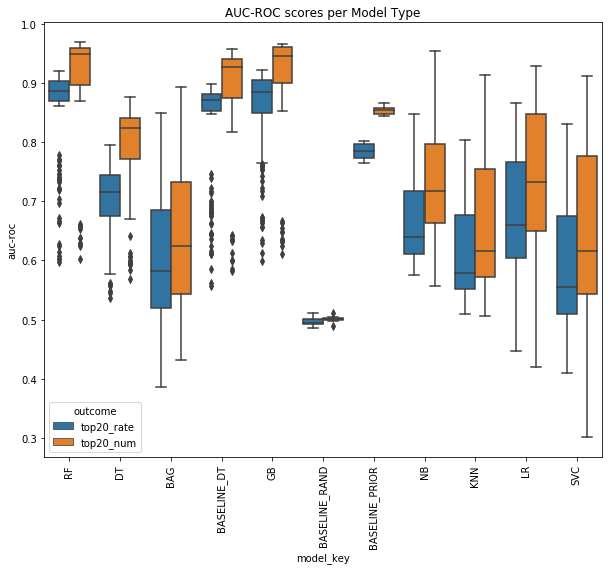

In [64]:
sns.boxplot(x='model_key', y='auc-roc', hue='outcome', data =results)
plt.title("AUC-ROC scores per Model Type")
plt.xticks(rotation=90)


C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


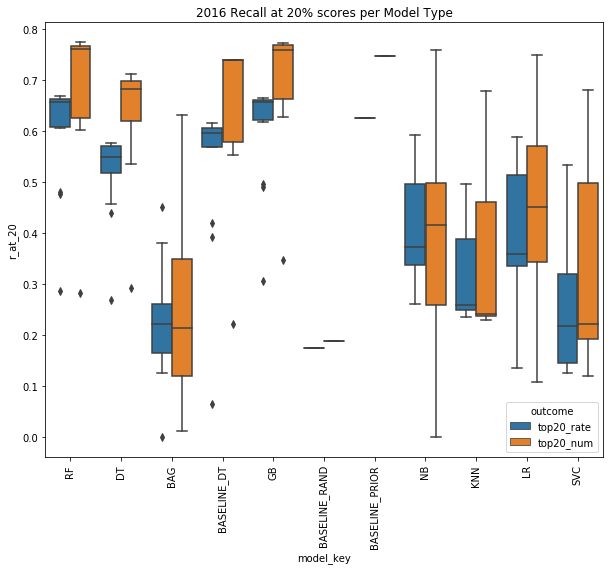

In [78]:
df_2016 = results[results['testing_dates'] == '(datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2016, 12, 31, 0, 0))']
#results.tail()
sns.boxplot(x='model_key', y='r_at_20', hue='outcome', data =df_2016)
plt.title("2016 Recall at 20% scores per Model Type")
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [10, 8]



In [76]:
format_left = "(datetime.datetime(%Y, %M, %d, 0, 0"
format_right = "datetime.datetime(%Y, %M, %d, 0, 0))"

start = []
end = []
for rec in results['training_dates']:
    left, right = rec.split('), ')
    start.append(datetime.datetime.strptime(left, format_left))
    end.append()
    
for rec in results['testing_dates']:
        



#print(datetime.datetime.strptime(left, format_left))
#print(datetime.datetime.strptime(right, format_right))
 




error: unbalanced parenthesis at position 0